In [ ]:
# relevant imports
from datetime import datetime
import requests
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
#from fa2_modified import ForceAtlas2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import community as community_louvain 
from nltk.probability import FreqDist
from collections import defaultdict
from collections import Counter
import pycountry
from textblob import TextBlob
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.dowlnoad('punkt_tab')






c:\Users\leodb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# load data from the JSON file
with open('speeches.json', 'r') as f:
  speeches = json.load(f)

In [6]:
# download sentiment wordlist
with open('Data_Set_S1.txt', 'r') as f:
    data_S1 = f.read()

data_S1 = [line.split('\t') for line in data_S1.strip().split('\n')]
data_S1 = data_S1[3:]
data_S1 = pd.DataFrame(data_S1[1:], columns = data_S1[0])

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_text(text):
    """
    Process the text by tokenizing, removing punctuation, setting to lowercase, removing stopwords, and lemmatizing.
    """
    # tokenize text
    words = word_tokenize(text)
    # remove punctuation
    words = [word for word in words if word.isalpha()]
    # set to lowercase
    words = [word.lower() for word in words]
    # remove stopwords
    words = [word for word in words if word not in stop_words]
    # lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return words   

In [8]:
def sentiment_score(text):
    """
    Calculate the sentiment score of the text based on the sentiment wordlist.
    """
    # process text to get words
    words = process_text(text)
    freq_dist = FreqDist(words)
    # calculate sentiment score
    score = sum(freq_dist[word] *float(data_S1[data_S1['word']==word]['happiness_average'].values[0]) 
                for word in freq_dist if word in data_S1['word'].values)

    total_frequency = sum(freq_dist[word] for word in freq_dist if word in data_S1['word'].values)
    if total_frequency > 0:  # to avoid division by zero
        return score / total_frequency
    else:
        return 0.0

In [11]:
# get text embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode([speech['transcript'] for speech in speeches])

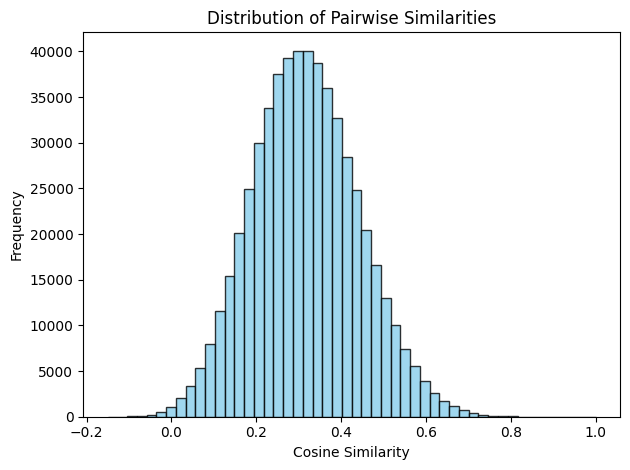

In [12]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)
# Get the upper triangle of the matrix without the diagonal (remove repeated pairs and self-similarity)
upper_triangle = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
# Plot bar chart
hist, bin_edges = np.histogram(upper_triangle.flatten(), bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities')
plt.tight_layout()
plt.show()

In [13]:
# Create a graph where nodes are speeches and edges are similarities
SpeechNet = nx.Graph()

# Add nodes with attributes (each node is a speech)
for i, speech in enumerate(speeches):
    SpeechNet.add_node(i, title=speech['title'], president=speech['president'], date=speech['date'], transcript=speech['transcript'])

# Add edges between speeches with similarity greater than 0.625
threshold = 0.625
for i in range(len(speeches)):
    for j in range(i + 1, len(speeches)):
        if similarity_matrix[i][j] > threshold:
            SpeechNet.add_edge(i, j, weight=similarity_matrix[i][j])

In [ ]:
# sentiment for every node's transcript
sentiments = {}
for node, data in SpeechNet.nodes(data=True):
    speech = node
    transcript = data['transcript']
    sentiments[speech] = sentiment_score(transcript)

In [15]:
# read sentiment scores from file
sentiments = {}
with open('sentiments.txt', 'r') as f:
    for line in f:
        speech, sentiment = line.strip().split(' | ')
        speech = int(speech)
        sentiments[speech] = float(sentiment)

# assign sentiment scores to nodes
nx.set_node_attributes(SpeechNet, sentiments, 'sentiment')

In [16]:
# average sentiment
average_sentiment = sum(sentiments.values()) / len(sentiments)
print(f"Average sentiment of the speeches: {average_sentiment}")

# median sentiment
median_sentiment = np.median(list(sentiments.values()))
print(f"Median sentiment of the speeches: {median_sentiment}")

# variance of sentiment
variance_sentiment = np.var(list(sentiments.values()))
print(f"Variance of sentiment of the speeches: {variance_sentiment}")

# 25th percentile of sentiment
percentile_25 = np.percentile(list(sentiments.values()), 25)
print(f"25th percentile of sentiment of the speeches: {percentile_25}")

# 75th percentile of sentiment
percentile_75 = np.percentile(list(sentiments.values()), 75)
print(f"75th percentile of sentiment of the speeches: {percentile_75}")

Average sentiment of the speeches: 5.638436693821281
Median sentiment of the speeches: 5.6295686619718275
Variance of sentiment of the speeches: 0.019115696090402423
25th percentile of sentiment of the speeches: 5.55791905855339
75th percentile of sentiment of the speeches: 5.715860427716681


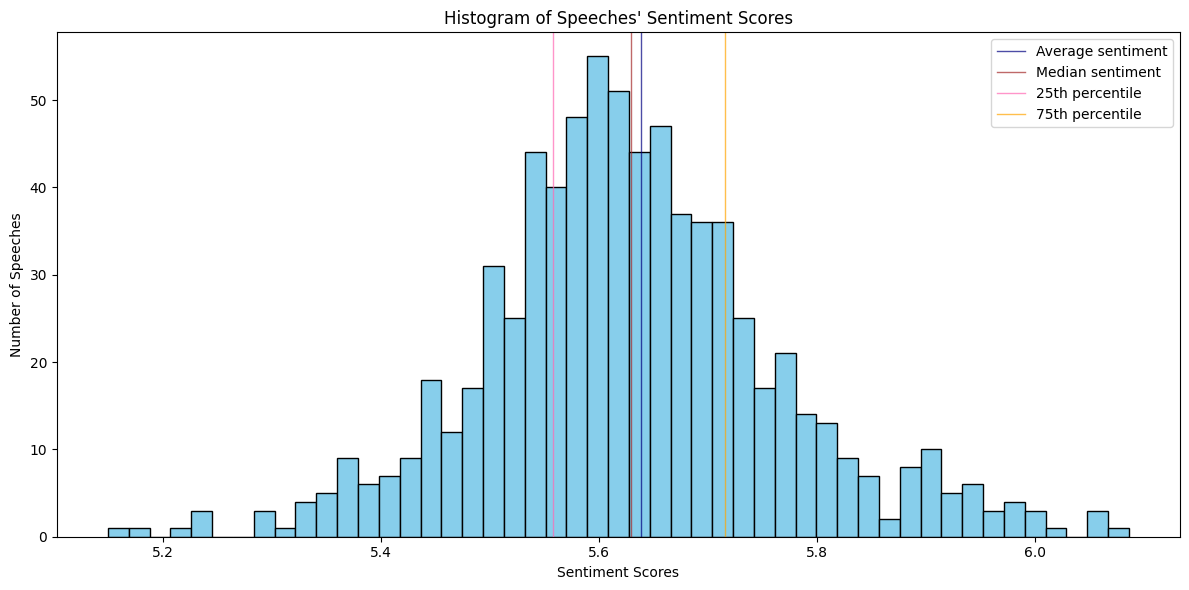

In [17]:
# plot of sentiment distribution of speeches

# Create bins for the sentiment scores
min_sentiment = min(sentiments.values())
max_sentiment = max(sentiments.values())
v = np.arange(min_sentiment, max_sentiment + variance_sentiment, variance_sentiment)  

# Count the number of artists in each bin
binned_counts, bin_edges = np.histogram(list(sentiments.values()), bins=v)

# bar plot for the histogram
plt.figure(figsize=(12, 6))
plt.bar(bin_edges[:-1], binned_counts, width=np.diff(bin_edges), color='skyblue', edgecolor='black')
# average sentiment line
plt.axvline(average_sentiment, color='navy', linestyle='-', linewidth=1, alpha=0.7)
# median sentiment line
plt.axvline(median_sentiment, color='brown', linestyle='-', linewidth=1, alpha=0.7)
# 25th percentile line
plt.axvline(percentile_25, color='hotpink', linestyle='-', linewidth=1, alpha=0.7)
# 75th percentile line
plt.axvline(percentile_75, color='orange', linestyle='-', linewidth=1, alpha=0.7)
plt.legend(['Average sentiment', 'Median sentiment', '25th percentile', '75th percentile'])
plt.title('Histogram of Speeches\' Sentiment Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Speeches')

plt.tight_layout()
plt.show()

In [18]:
# create tf lists for each speech's transcript
tf_speech = {}
for speech, data in SpeechNet.nodes(data=True):
    text = data['transcript']
    words = process_text(text)
    tf_speech[speech] = pd.Series(words).value_counts()

In [19]:
# Calculate document frequency for each word
doc_freq = defaultdict(int)
for tf in tf_speech.values():
    for word in tf.index:
        doc_freq[word] += 1

# Calculate IDF for each word
idf_speech = {word: np.log(len(tf_speech) / df) for word, df in doc_freq.items()}

In [20]:
# Calculate TF-IDF for each speech
tfidf_speech = {}
for speech, tf in tf_speech.items():
    tfidf_speech[speech] = {word: tf[word] * idf_speech[word] for word in tf.index}

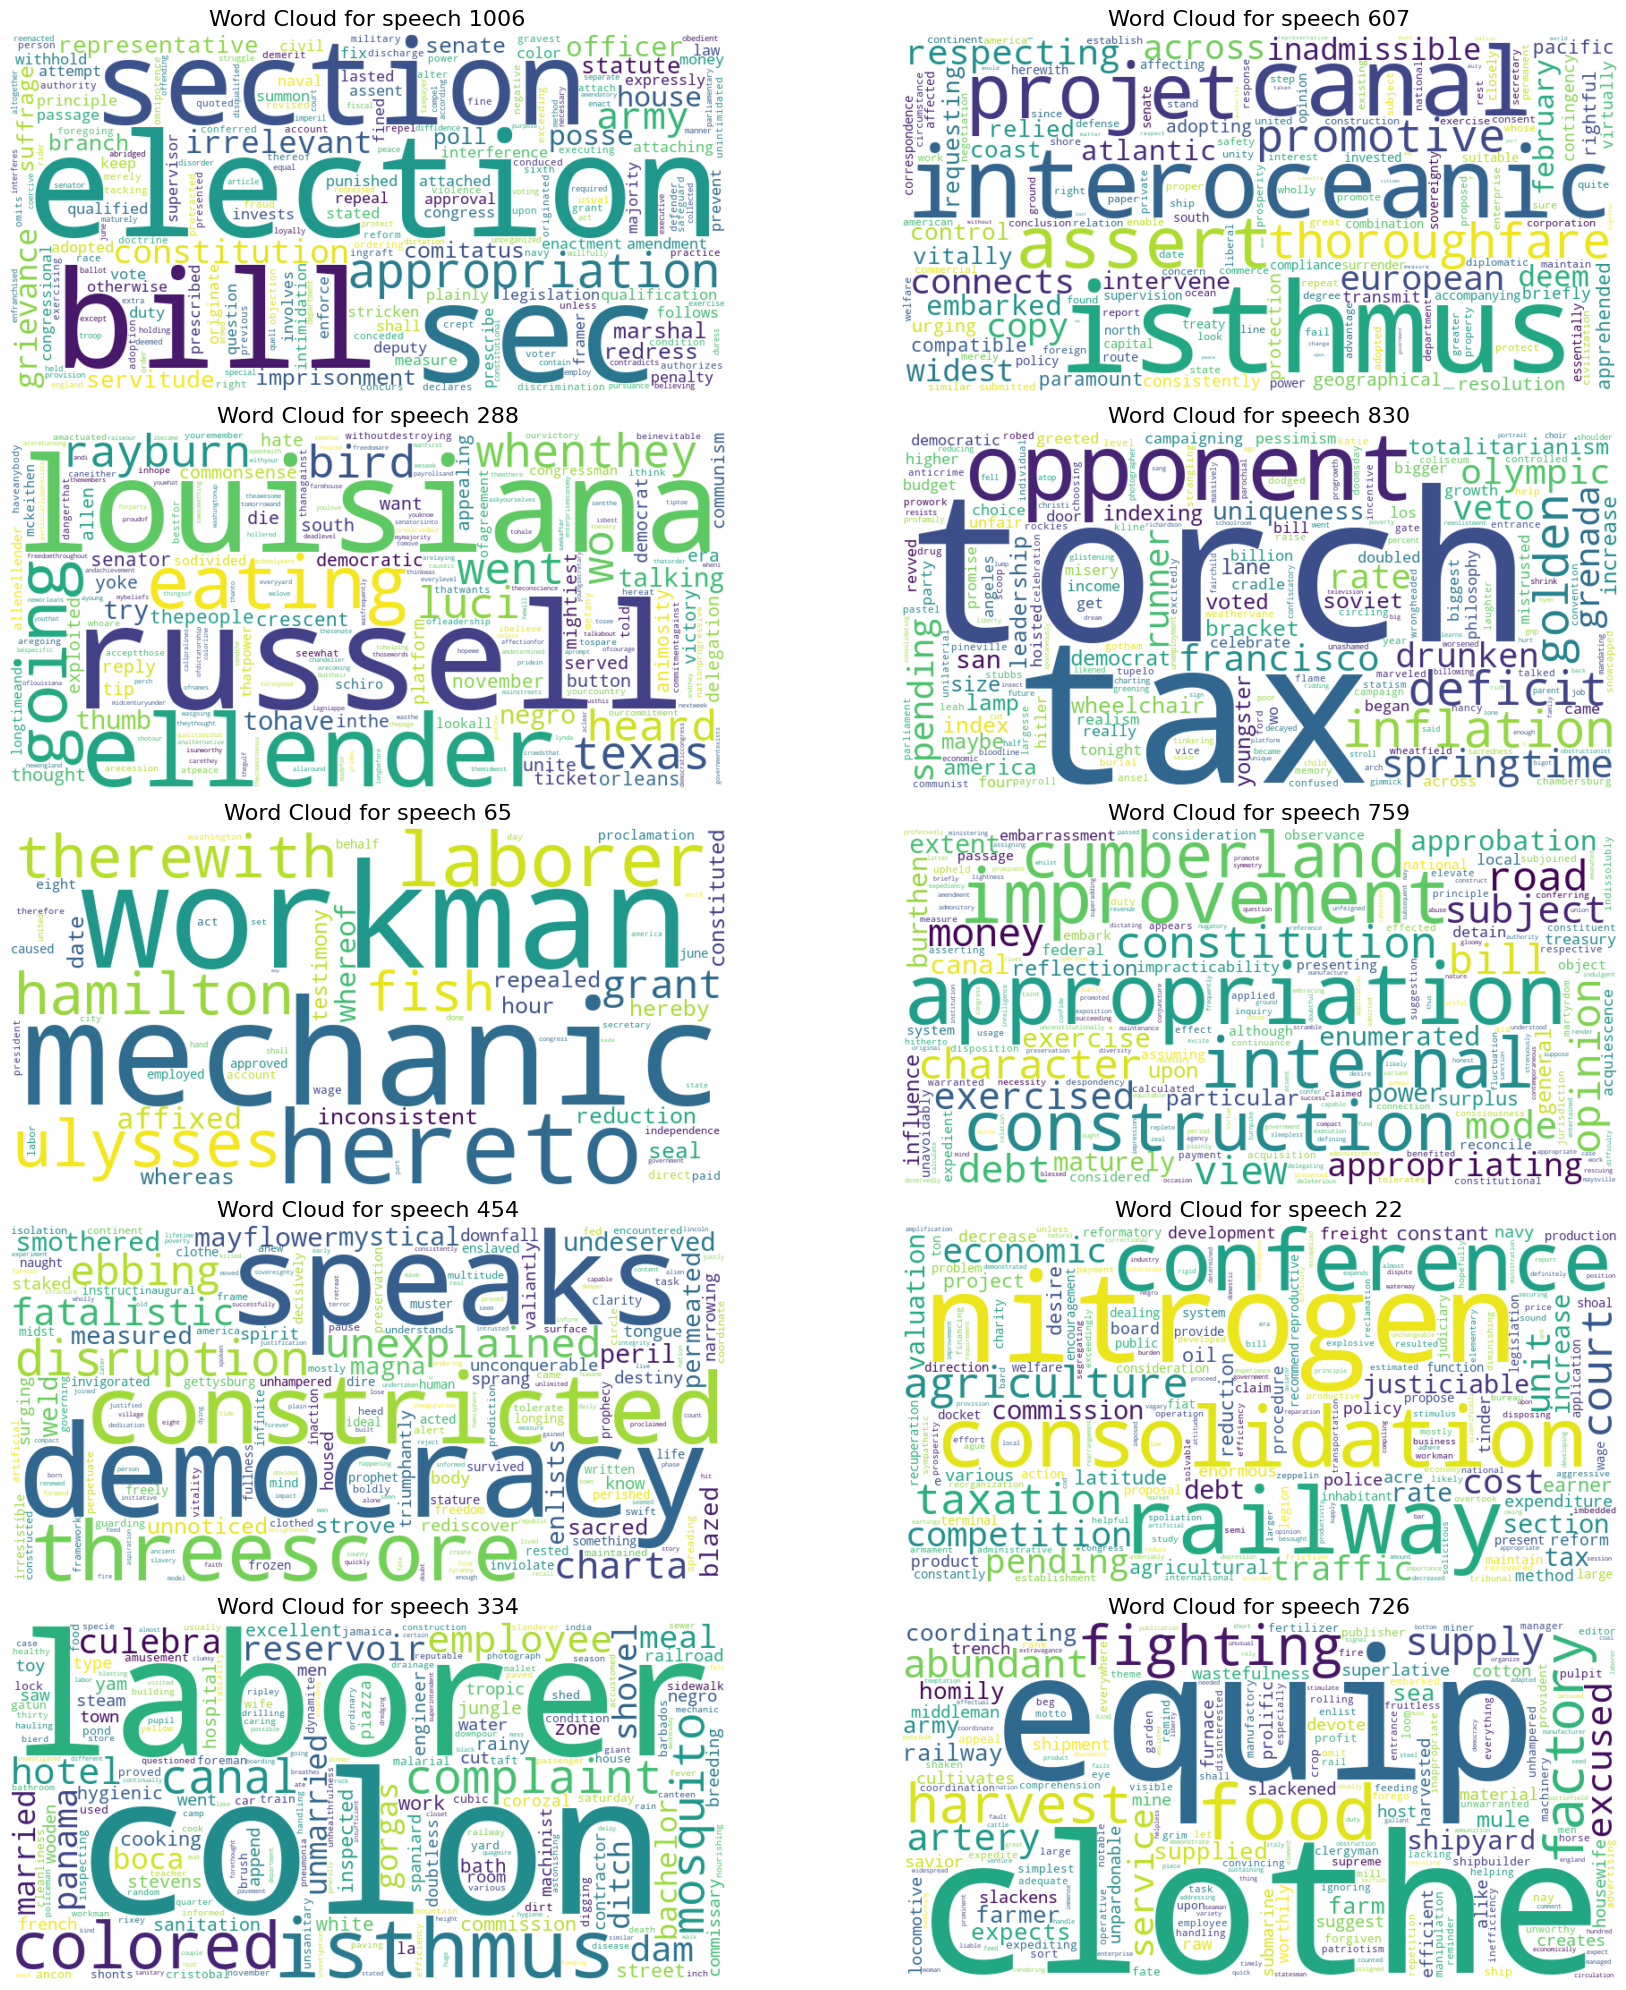

In [21]:
# Get the top 10 happiest speeches
happiest_speeches = sorted(sentiments, key=sentiments.get, reverse=True)[:10]

# Filter the tfidf_speech dictionary to include only the top 10 happiest speeches
top_tfidf_speeches = {speech: tfidf_speech[speech] for speech in happiest_speeches}

# Create word clouds for the top 10 happiest speeches
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
for i, (speech, tfidf) in enumerate(top_tfidf_speeches.items()):
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color='white').generate_from_frequencies(tfidf)
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for speech {speech}", fontsize=16)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
plt.tight_layout()
plt.show()

In [22]:
# print "legend" of 10 happiest speeches
for i, speech in enumerate(happiest_speeches):
    print(f"{i+1}. Speech {speech}")
    print(f"{SpeechNet.nodes[speech]['title']} by {SpeechNet.nodes[speech]['president']}.")

1. Speech 1006
April 29, 1879: Veto of Army Appropriations Bill by Rutherford B. Hayes.
2. Speech 607
March 8, 1880: Message Regarding Central American Canal by Rutherford B. Hayes.
3. Speech 288
October 9, 1964: Speech at the Jung Hotel, New Orleans by Lyndon B. Johnson.
4. Speech 830
August 23, 1984: Republican National Convention by Ronald Reagan.
5. Speech 65
May 19, 1869: Proclamation Establishing Eight Hour Workday by Ulysses S. Grant.
6. Speech 759
May 27, 1830: Veto Message Regarding Funding of Infrastructure Development by Andrew Jackson.
7. Speech 454
January 20, 1941: Third Inaugural Address by Franklin D. Roosevelt.
8. Speech 22
December 3, 1924: Second Annual Message by Calvin Coolidge.
9. Speech 334
December 17, 1906: Message Regarding Conditions in Panama by Theodore Roosevelt.
10. Speech 726
April 17, 1917: Message Regarding World War I by Woodrow Wilson.


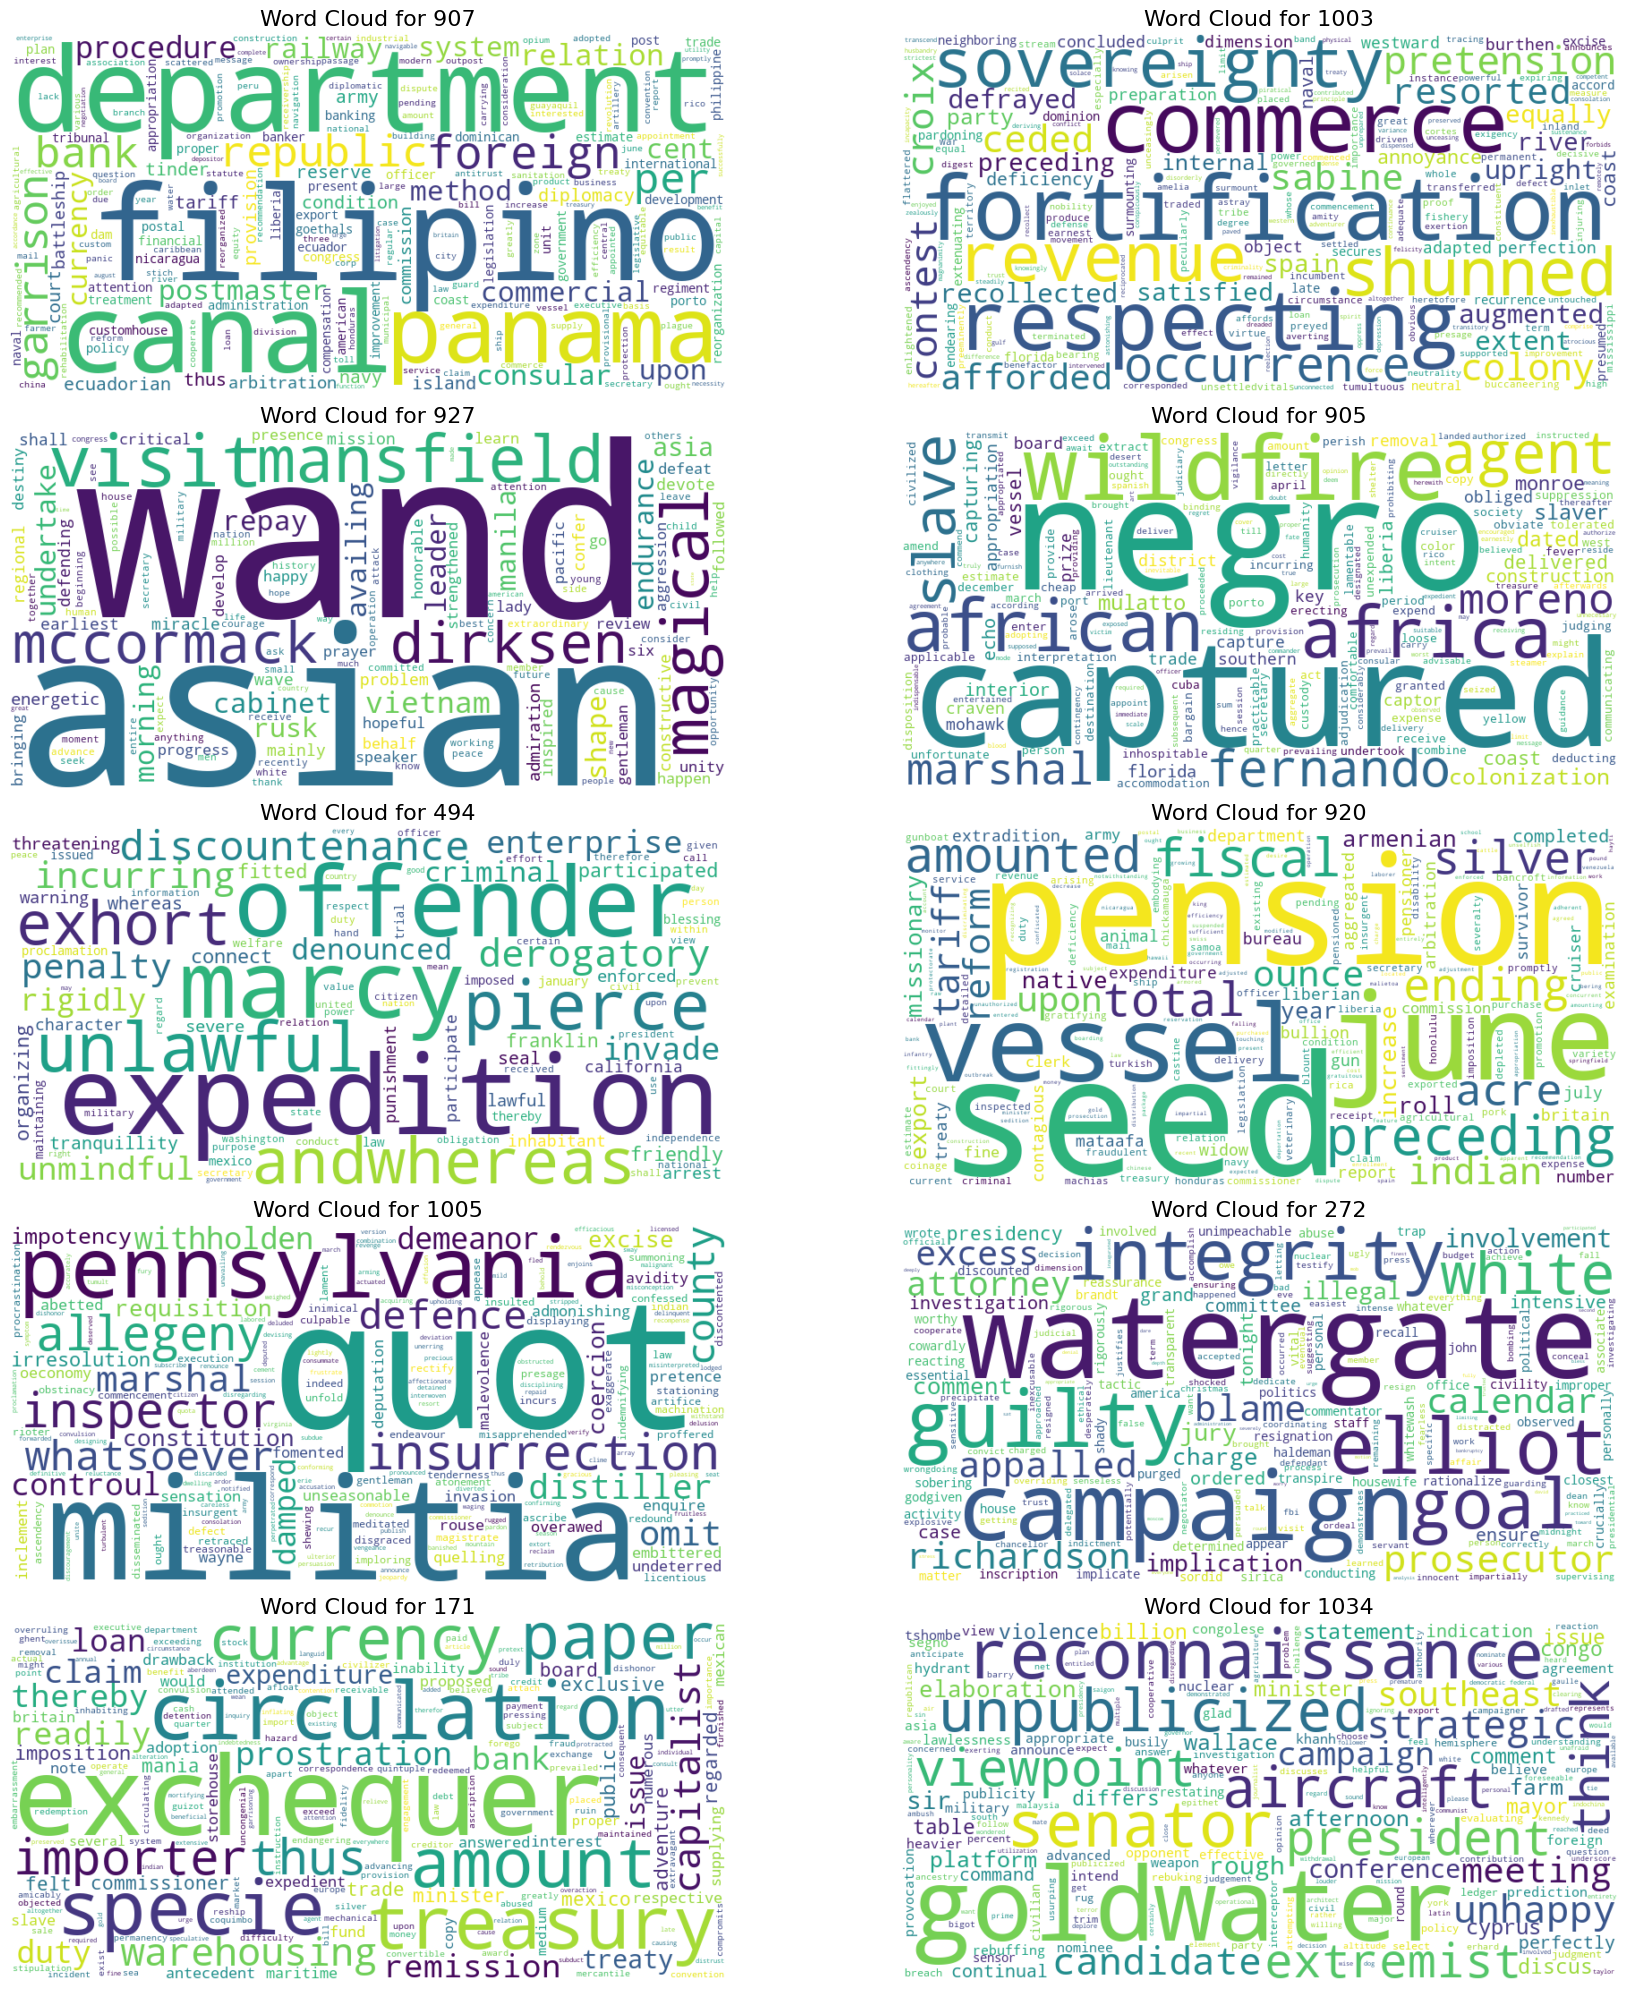

In [23]:
# Get the top 10 saddest speeches
saddest_speeches = sorted(sentiments, key=sentiments.get, reverse=False)[:10]

# Filter the tfidf_speech dictionary to include only the top 10 saddest speeches
top_tfidf_speeches = {speech: tfidf_speech[speech] for speech in saddest_speeches}

# Create word clouds for the top 10 saddest speeches
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
for i, (speech, tfidf) in enumerate(top_tfidf_speeches.items()):
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, collocations=False, background_color='white').generate_from_frequencies(tfidf)
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Word Cloud for {speech}", fontsize=16)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.3, wspace=0.3)
plt.tight_layout()
plt.show()

In [24]:
# print "legend" of 10 saddest speeches
for i, speech in enumerate(saddest_speeches):
    print(f"{i+1}. Speech {speech}")
    print(f"{SpeechNet.nodes[speech]['title']} by {SpeechNet.nodes[speech]['president']}.")

1. Speech 907
December 3, 1912: Fourth Annual Message by William Taft.
2. Speech 1003
March 5, 1821: Second Inaugural Address by James Monroe.
3. Speech 927
October 17, 1966: Remarks on Departing for the Asia-Pacific Trip by Lyndon B. Johnson.
4. Speech 905
May 19, 1860: Message on the Capture of the Wildfire by James Buchanan.
5. Speech 494
January 18, 1854: Proclamation by Franklin Pierce.
6. Speech 920
December 4, 1893: First Annual Message (Second Term) by Grover Cleveland.
7. Speech 1005
November 19, 1794: Sixth Annual Message to Congress by George Washington.
8. Speech 272
April 30, 1973: Address to the Nation About the Watergate Investigations by Richard M. Nixon.
9. Speech 171
December 6, 1842: Second Annual Message by John Tyler.
10. Speech 1034
July 24, 1964: Press Conference at the State Department by Lyndon B. Johnson.


##### Context of topics over time
Provide a focused view of how often differrent topics was mentioned in the speeches

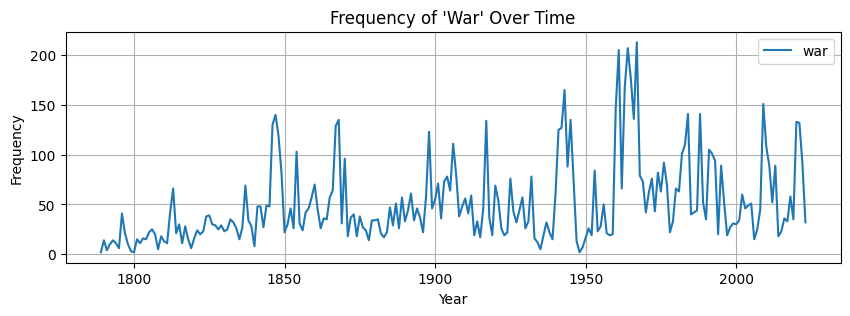

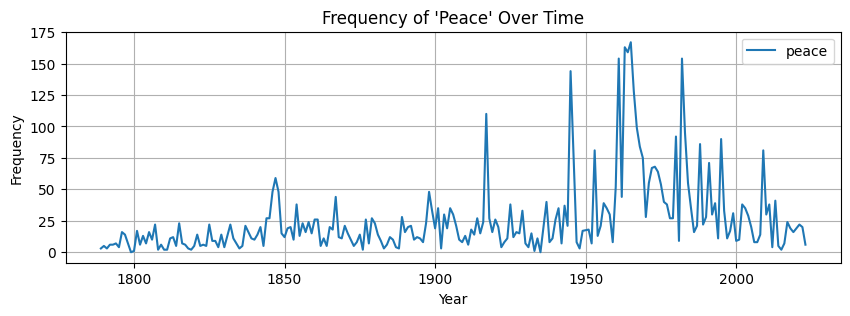

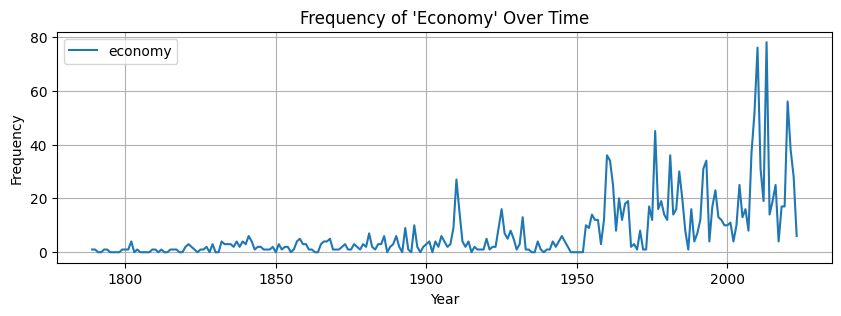

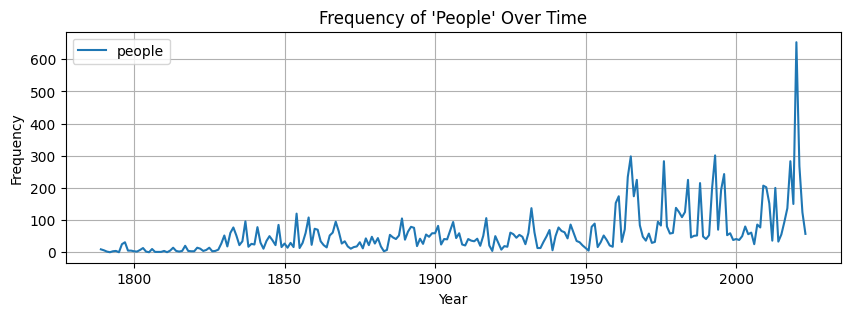

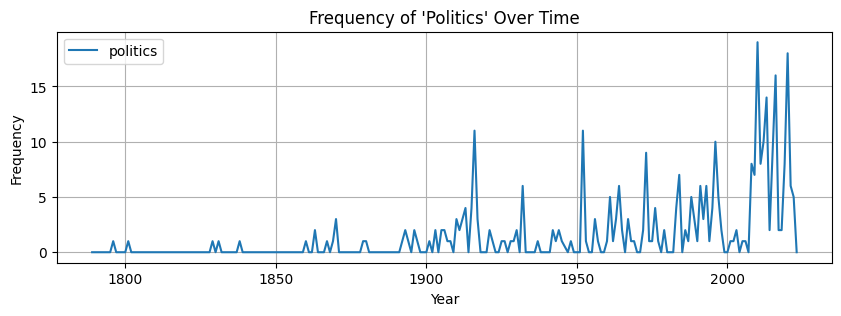

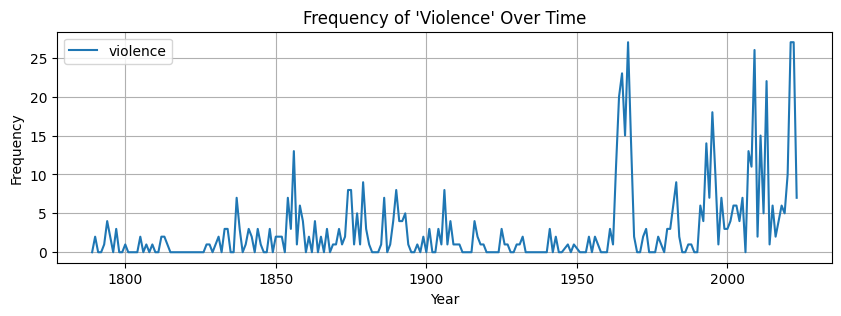

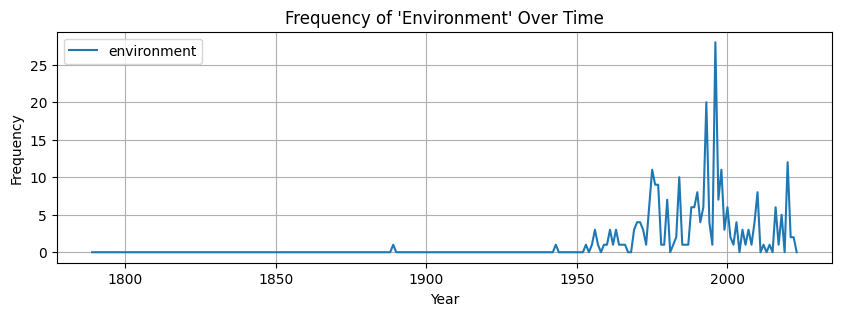

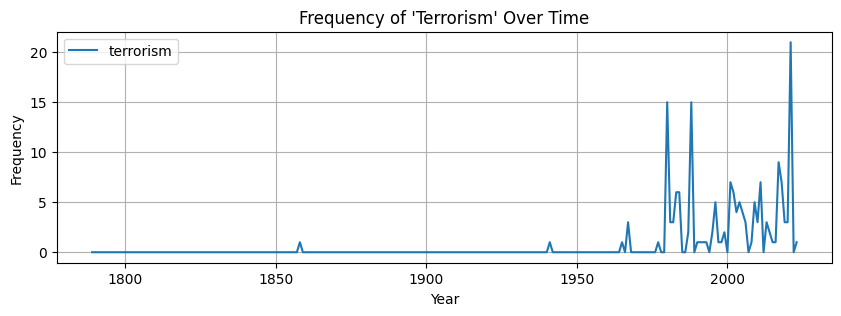

In [ ]:
# Topics to analyze
topics = ["war", "peace", "economy", "people", "politics", "violence", "environment", "terrorism"]

# Extract transcripts and dates from the dataset
speeches_year = pd.DataFrame(speeches)
speeches_year['date'] = pd.to_datetime(speeches_year['date'], errors='coerce')  # Parse dates if available

# Dictionary to store topic frequencies over time
topic_counts = {topic: Counter() for topic in topics}

# Count the occurrences of each topic in the speeches
for _, row in speeches_year.iterrows():
    if pd.notnull(row['date']) and isinstance(row['transcript'], str):
        year = row['date'].year
        text = row['transcript'].lower()
        for topic in topics:
            topic_counts[topic][year] += text.count(topic)

# Convert to a DataFrame
topic_counts_df = pd.DataFrame(topic_counts).fillna(0).sort_index()

# Plot trends for each topic
for topic in topics:
    plt.figure(figsize=(10, 3))
    plt.plot(topic_counts_df.index, topic_counts_df[topic], label=topic)
    plt.title(f"Frequency of '{topic.capitalize()}' Over Time")
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()



##### Most mentioned countries in the speeches

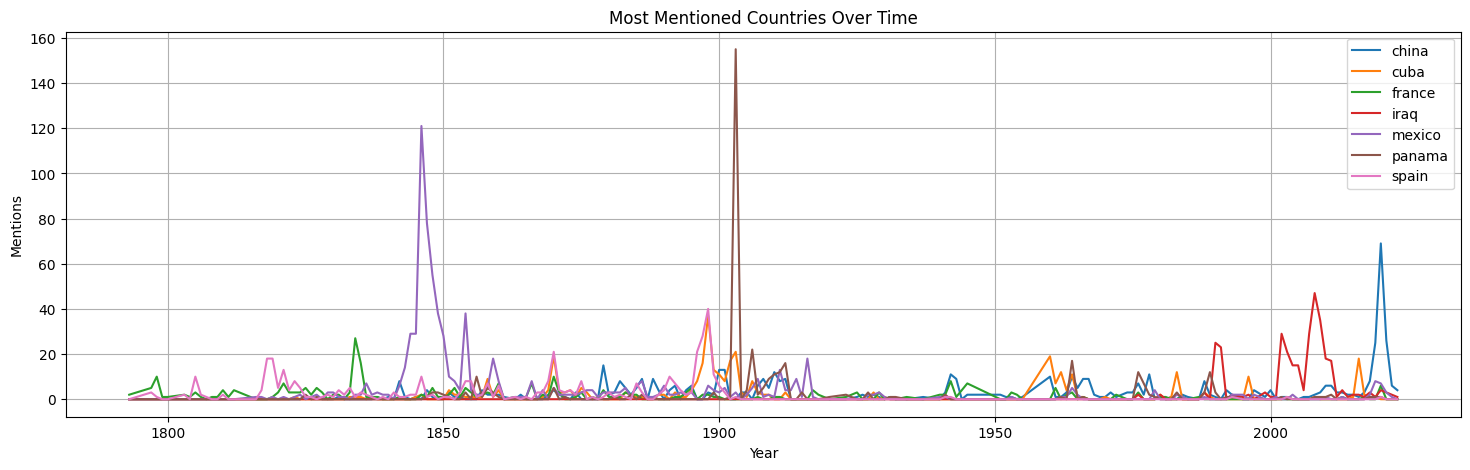

In [ ]:
# Get country names
country_names = set()
for country in pycountry.countries:
    country_names.add(country.name.lower())
    if hasattr(country, "official_name"):
        country_names.add(country.official_name.lower())

# Counter for each year
country_mentions = Counter()

# Extract country mentions from speeches
for _, row in speeches.iterrows():
    if pd.notnull(row['date']) and isinstance(row['transcript'], str):
        year = row['date'].year
        words = row['transcript'].lower().split()
        for word in words:
            if word in country_names:
                country_mentions[(year, word)] += 1

# Convert to a DataFrame
country_mentions_df = pd.DataFrame(
    [
        {"year": year, "country": country, "count": count}
        for (year, country), count in country_mentions.items()
    ]
)

# Select the most frequently mentioned countries over time
top_countries = (
    country_mentions_df.groupby("country")["count"].sum().sort_values(ascending=False).head(7).index
)
filtered_data = country_mentions_df[country_mentions_df["country"].isin(top_countries)]

# Pivot data
pivoted_data = filtered_data.pivot(index="year", columns="country", values="count").fillna(0)

# Plot the most mentioned countries
plt.figure(figsize=(18, 5))
for country in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[country], label=country)
plt.title("Most Mentioned Countries Over Time")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.legend()
plt.grid(True)
plt.show()

##### Speaker Sentiment Profiling

Compare the sentiment expressed by different presidents to capture the overall emotional of a group of speeches calculating the mean polarity and mean subjectivity.

1. Polarity: Helps understand if a speaker is generally positive (e.g., optimistic) or negative (e.g., critical) in their rhetoric. Ranging from:
    - -1.0 (very negative) to 1.0 (very positive)
    -  polarity of 0.0 indicates a neutral sentiment

2. Subjectivity: Provides insight into whether a speaker relies more on personal opinions or sticks to facts and objective statements. Ranging from:
    - 0.0 (completely objective) to 1.0 (completely subjective)

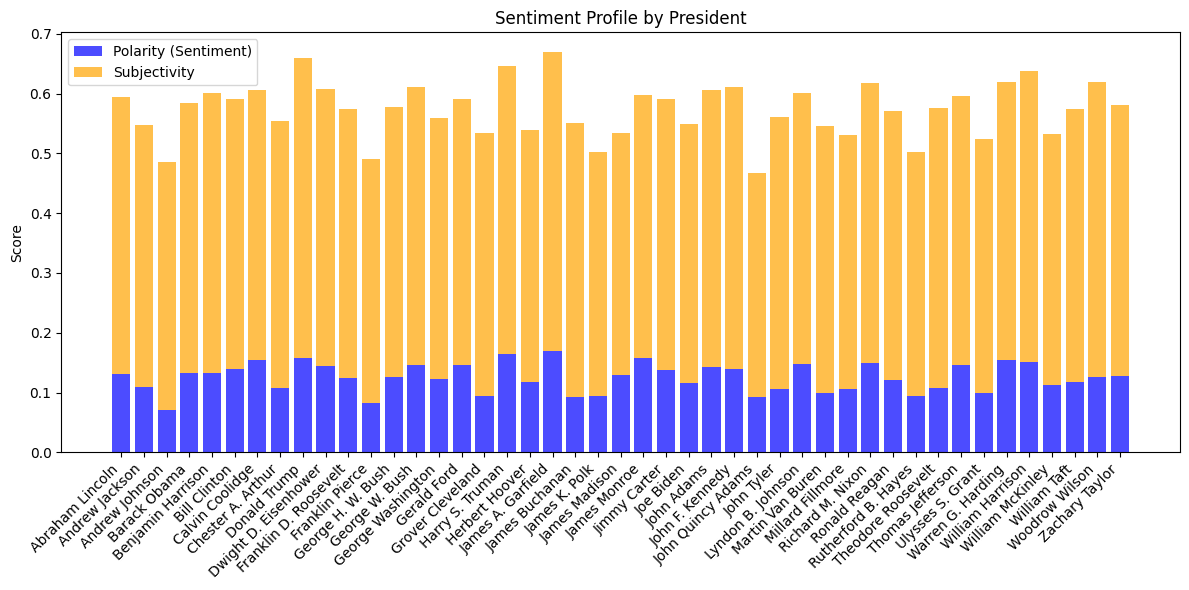

In [ ]:
# Extract president from the dataset
speech_df = pd.DataFrame(speeches)
speech_df["president"] = speech_df["president"].str.strip()  # Clean president names

# Analyze sentiment for each speech
speech_df["polarity"] = speech_df["transcript"].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
speech_df["subjectivity"] = speech_df["transcript"].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else None)

# Group by president and calculate mean sentiment scores
sentiment_by_president = speech_df.groupby("president")[["polarity", "subjectivity"]].mean().reset_index()

# Plot sentiment profiles
plt.figure(figsize=(12, 6))
x = sentiment_by_president["president"]
polarity = sentiment_by_president["polarity"]
subjectivity = sentiment_by_president["subjectivity"]

plt.bar(x, polarity, label="Polarity (Sentiment)", alpha=0.7, color="blue")
plt.bar(x, subjectivity, label="Subjectivity", alpha=0.7, color="orange", bottom=polarity)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.ylabel("Score")
plt.title("Sentiment Profile by President")
plt.legend()
plt.tight_layout()
plt.show()


##### Comparative Sentiment Analysis Across Eras

Compare the overall emotional tone or sentiment of a group of speeches over a specific period including historical events

- -1.0: Extremely negative sentiment (e.g., critical, pessimistic, angry).
- 0.0: Neutral sentiment (e.g., factual, balanced).
- 1.0: Extremely positive sentiment (e.g., optimistic, joyful, celebratory).

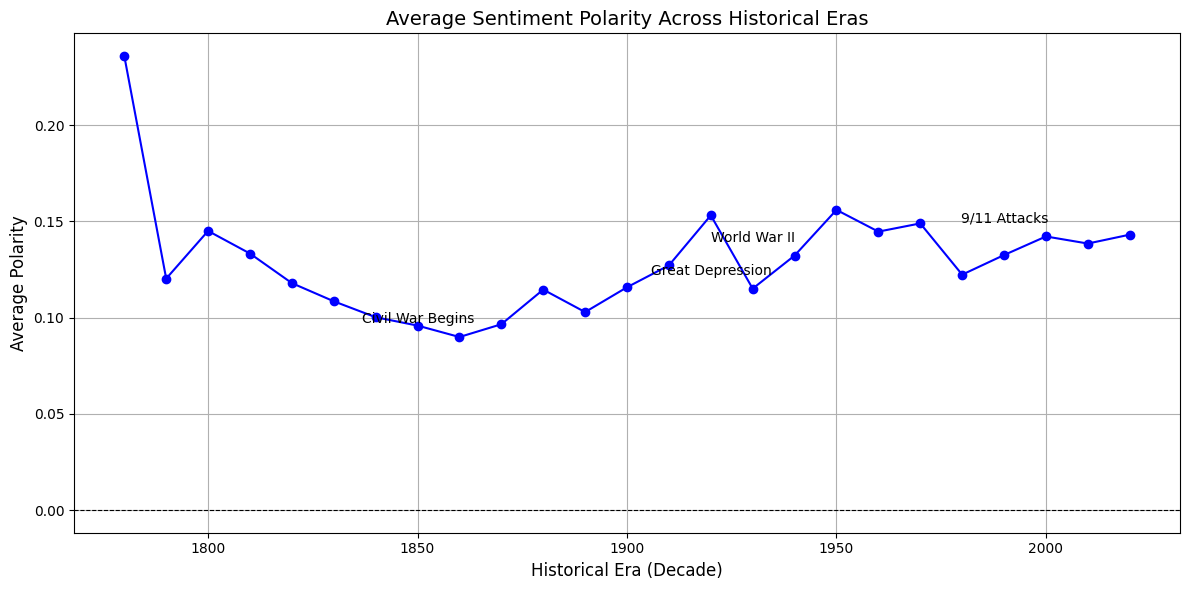

In [ ]:
# Calculate sentiment polarity for each speech
speech_df["polarity"] = speech_df["transcript"].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)

# Define historical divide in decades
speech_df["era"] = speech_df["date"].dt.year // 10 * 10  # Group by decades

# Calculate average sentiment polarity for each decade
era_sentiment = speech_df.groupby("era")["polarity"].mean().reset_index()

# Plot sentiment trends across eras
plt.figure(figsize=(12, 6))
plt.plot(era_sentiment["era"], era_sentiment["polarity"], marker="o", linestyle="-", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Average Sentiment Polarity Across Historical Eras", fontsize=14)
plt.xlabel("Historical Era (Decade)", fontsize=12)
plt.ylabel("Average Polarity", fontsize=12)
plt.grid(True)

# Annotate key events
key_events = {
    1860: "Civil War Begins",
    1930: "Great Depression",
    1940: "World War II",
    2000: "9/11 Attacks",
}
for era, event in key_events.items():
    if era in era_sentiment["era"].values:
        plt.annotate(event, (era, era_sentiment.loc[era_sentiment["era"] == era, "polarity"].values[0]),
                     textcoords="offset points", xytext=(-30, 10), ha="center", fontsize=10)

plt.tight_layout()
plt.show()


Sentiment analysis focusing on economic factors by isolating speeches or parts of speeches related to the economy.

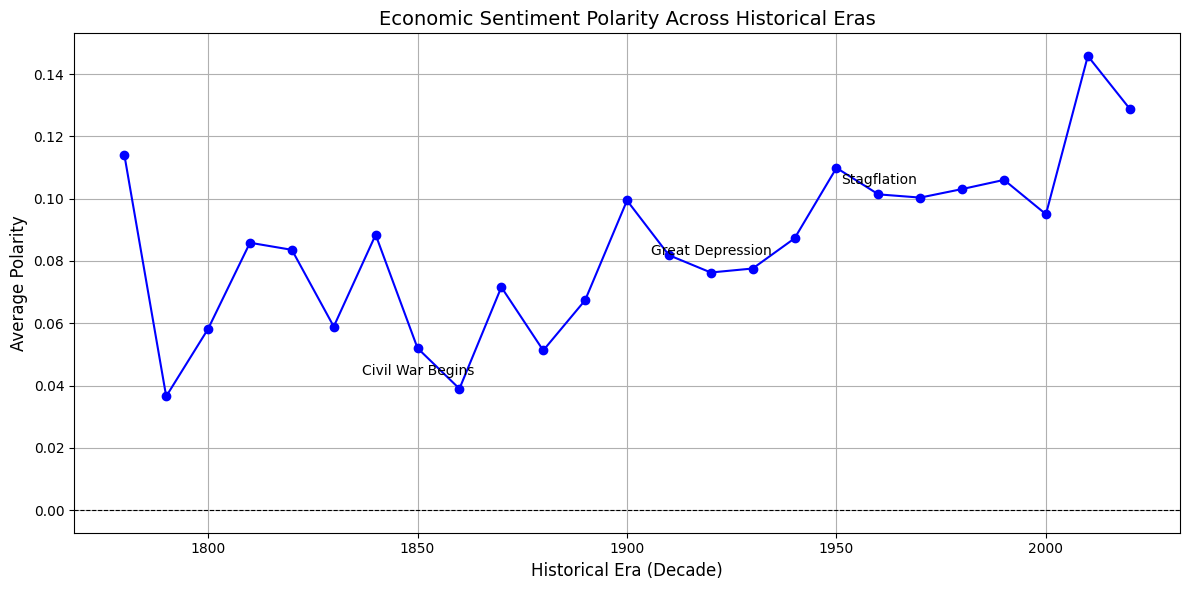

In [ ]:
# Filter economy related speeches
economy_keywords = ["economy", "trade", "tax", "revenue", "jobs", "debt", "inflation", "market"]
speech_df_economy = pd.DataFrame(speeches)

def extract_economic_segments(text):
    if isinstance(text, str):
        sentences = text.split('.')
        return ' '.join([sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in economy_keywords)])
    return None

speech_df["economic_text"] = speech_df["transcript"].apply(extract_economic_segments)

# Perform sentiment analysis on economy-related segments
speech_df["polarity"] = speech_df["economic_text"].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)

# Group by historical periods (e.g., decades)
speech_df["era"] = speech_df["date"].dt.year // 10 * 10  # Group by decades
economic_sentiment = speech_df.groupby("era")["polarity"].mean().reset_index()

# Plot economic sentiment trends
plt.figure(figsize=(12, 6))
plt.plot(economic_sentiment["era"], economic_sentiment["polarity"], marker="o", linestyle="-", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Economic Sentiment Polarity Across Historical Eras", fontsize=14)
plt.xlabel("Historical Era (Decade)", fontsize=12)
plt.ylabel("Average Polarity", fontsize=12)
plt.grid(True)

# Annotate with key economic events
key_events = {
    1860: "Civil War Begins",
    1930: "Great Depression",
    1970: "Stagflation",
}
for era, event in key_events.items():
    if era in economic_sentiment["era"].values:
        plt.annotate(event, (era, economic_sentiment.loc[economic_sentiment["era"] == era, "polarity"].values[0]),
                     textcoords="offset points", xytext=(-30, 10), ha="center", fontsize=10)

plt.tight_layout()
plt.show()
